In [66]:
%matplotlib inline

import operator
import numpy
import matplotlib.pyplot as plt
from iris.analysis.cartography import rotate_pole
import cartopy.crs as ccrs

In [67]:
# Define some functions for adjusting the longitude range

def single2list(item, numpy_array=False):
    """Check if item is a list, then convert if not."""
    
    try:
        test = len(item)
    except TypeError:
        output = [item,]
    else:
        output = item 
        
    if numpy_array and not isinstance(output, numpy.ndarray):
        return numpy.array(output)
    else:
        return output

    
def adjust_lon_range(lons, radians=True, start=0.0):
    """Express longitude values in a 360 degree (or 2*pi radians) interval.

    Args:
      lons (list/tuple): Longitude axis values (monotonically increasing)
      radians (bool): Specify whether input data are in radians (True) or
        degrees (False). Output will be the same units.
      start (float, optional): Start value for the output interval (add 360 degrees or 2*pi
        radians to get the end point)
    
    """   
    
    lons = single2list(lons, numpy_array=True)
    
    interval360 = 2.0*numpy.pi if radians else 360.0
    end = start + interval360    
    
    less_than_start = numpy.ones([len(lons),])
    while numpy.sum(less_than_start) != 0:
        lons = numpy.where(lons < start, lons + interval360, lons)
        less_than_start = lons < start
    
    more_than_end = numpy.ones([len(lons),])
    while numpy.sum(more_than_end) != 0:
        lons = numpy.where(lons >= end, lons - interval360, lons)
        more_than_end = lons >= end

    return lons

In [68]:
# Get the correct answer for a pole at 20N, 230E

fin = open('equator_20N_230E.txt', 'r')
lats = []
lons = []
for line in fin:
    pair = line.rstrip('\n')
    lat, lon = pair.split(',')
    lats.append(float(lat))
    lons.append(float(lon))
fin.close()

lons = adjust_lon_range(numpy.array(lons), radians=False, start=-180)  # seems to only work for range (-180, 180)
sorted_lats, sorted_lons = zip(*sorted(zip(lats, lons), key=operator.itemgetter(1)))  
# Above prevents problem of 0/360 lon crossing
# (I'm not concerned about the order of the points for this example)

clons = numpy.array(sorted_lons)
clats = numpy.array(sorted_lats)

The correct answer contained in `equator_20N_230E.txt` was obtained using `coordinate_rotation.rotate_spherical()`:  
https://github.com/DamienIrving/climate-analysis/blob/master/modules/coordinate_rotation.py

In [69]:
# Define a function for rotating the equator

def rotate_equator(pole_lon, pole_lat, correct_lons=None, correct_lats=None):
    """Rotate the equator."""
    
    print "Pole lon =", pole_lon
    print "Pole lat =", pole_lat
    
    orig_lons = numpy.arange(-180, 180, 5)
    orig_lats = numpy.zeros(orig_lons.shape)
    
    new_lons, new_lats = rotate_pole(orig_lons, orig_lats, pole_lon, pole_lat)
        
    proj = ccrs.PlateCarree()
    ax = plt.subplot(1, 1, 1, projection=proj)
    plt.sca(ax)
    
    plt.plot(orig_lons, orig_lats, transform=proj)
    plt.plot(new_lons, new_lats, transform=proj)
    
    plt.plot(correct_lons, correct_lats, transform=proj)
    
    pole_lon = adjust_lon_range(pole_lon, radians=False, start=-180)
    plt.plot(pole_lon, pole_lat, marker='o', color='aqua', transform=proj)
    
    plt.gca().coastlines()
    plt.show()

Pole lon = 230
Pole lat = 20


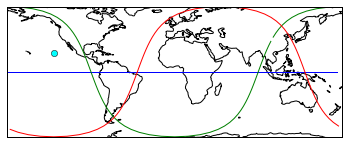

In [70]:
rotate_equator(230, 20, correct_lons=clons, correct_lats=clats)

In the figure above, the original equator is shown by the blue line. The green line shows the new equator for a north pole located at 20N, 260E (aqua dot) as calculated by `iris.analysis.cartography.rotate_pole`, while the red line shows where the new equator should actually be. This makes sense intuitively, as the green line passes much too close to the aqua dot (i.e. the equator should not pass close to the pole)

It seems that no matter which longitude the pole is located at, the new equator produced by  `iris.analysis.cartography.rotate_pole` does not move east/west:

Pole lon = 50
Pole lat = 20


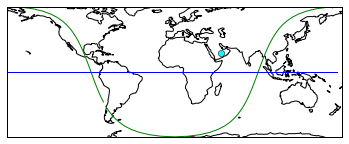

In [74]:
rotate_equator(50, 20)

Pole lon = 70
Pole lat = 20


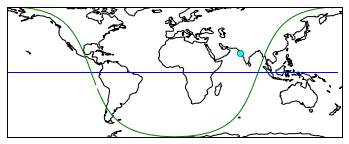

In [75]:
rotate_equator(70, 20)

Pole lon = 90
Pole lat = 20


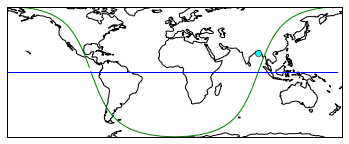

In [76]:
rotate_equator(90, 20)